In [1]:
import numpy as np
import time
from numba import jit
import matplotlib.pyplot as plt
#import argparse

In [2]:
#def parse_args():
#    parser = argparse.ArgumentParser(description="bose Hubbard model on a chain, dynamics")
#    parser.add_argument("-L",metavar="L",dest="L",type=np.int64,default=8,help="set L(=8, size)")
#    parser.add_argument("-t",metavar="t",dest="t",type=np.float64,default=0.0,help="set t(=0.0, time)")
#    return parser.parse_args()

In [3]:
## from https://github.com/XanaduAI/thewalrus/blob/master/thewalrus/_permanent.py
## use "np.searchsorted" instead of ".index"

@jit(nopython=True)
def perm_bbfg(M):  # pragma: no cover
    """
    Returns the permanent of a matrix using the bbfg formula in Gray ordering
    The code is a re-implementation from a Python 2 code found in
    `Permanent code golf
    <https://codegolf.stackexchange.com/questions/97060/calculate-the-permanent-as-quickly-as-possible>`_
    using Numba.
    Args:
        M (array) : a square array.
    Returns:
        float or complex: the permanent of a matrix ``M``
    """

    n = len(M)
    if n == 0:
        return M.dtype.type(1.0)
    row_comb = np.sum(M, 0)
    total = 0
    old_gray = 0
    sign = +1
    binary_power_dict = np.array([2**i for i in range(n)])
    num_loops = 2 ** (n - 1)
    for bin_index in range(1, num_loops + 1):
        reduced = np.prod(row_comb)
        total += sign * reduced
        new_gray = bin_index ^ (bin_index // 2)
        gray_diff = old_gray ^ new_gray
        gray_diff_index = np.searchsorted(binary_power_dict,gray_diff)
        new_vector = M[gray_diff_index]
        direction = 2 * ((old_gray > new_gray) - (old_gray < new_gray))
        for i in range(n):
            row_comb[i] += new_vector[i] * direction
        sign = -sign
        old_gray = new_gray
    return total / num_loops

In [4]:
@jit(nopython=True)
def calc_a_mi(L,L_A,tstep):
    x = np.zeros((L,L), dtype = np.complex128)
    for j in range(L):
        for k in range(L):
            x[j,k] = np.sin((j+1)*(k+1)*np.pi / (L+1))
    x *= np.sqrt(2.0 / (L+1))
    eps = np.array([-2.0 * np.cos((n+1) * np.pi / (L+1)) for n in range(L)])
    y = x @ (np.diag(np.exp(1j * eps * tstep))) @ x
    z = np.zeros((L,L), dtype = np.complex128)
    for j in range(L):
        for k in range(L):
            for m in range(L_A):
                z[j,k] += y[j,m].conjugate() * y[k,m]
    dlt = np.eye(L,dtype=np.complex128)
    a = np.vstack( (np.hstack((z,dlt-z)), np.hstack((dlt-z,z))) )
    return a

In [5]:
@jit(nopython=True)
def calc_a_cdw(L,L_A,tstep):
    x = np.zeros((L,L), dtype = np.complex128)
    for j in range(L):
        for k in range(L):
            x[j,k] = np.sin((j+1)*(k+1)*np.pi / (L+1))
    x *= np.sqrt(2.0 / (L+1))
    eps = np.array([-2.0 * np.cos((n+1) * np.pi / (L+1)) for n in range(L)])
    y = x @ (np.diag(np.exp(1j * eps * tstep))) @ x
    z = np.zeros((L//2,L//2), dtype = np.complex128)
    for j in range(L//2):
        for k in range(L//2):
            for m in range(L_A):
                z[j,k] += y[2*j,m].conjugate() * y[2*k,m]
    dlt = np.eye(L//2,dtype=np.complex128)
    a = np.vstack( (np.hstack((z,dlt-z)), np.hstack((dlt-z,z))) )
    return a

In [6]:
def get_dat(L,L_A,ts):
    start = time.time()
    data = []
    for tstep in ts:
#        a = calc_a_cdw_mi(L,L_A,tstep)
        a = calc_a_cdw(L,L_A,tstep)
        data.append([tstep,-np.log(perm_bbfg(a).real)])
    end = time.time()
    return np.array(data), end-start

In [7]:
#def main():
#    args = parse_args()
#    L = args.L
#    t = args.t
#    data, calctime = get_dat(L,L//2,[t])
#    np.savetxt("dat_ee_L"+"{}".format(L)+"_t"+"{}".format(t),data)
#    np.savetxt("dat_calctime_L"+"{}".format(L)+"_t"+"{}".format(t),[calctime])
#
#if __name__ == "__main__":
#    main()

In [8]:
L = 20
ts = np.linspace(0,2*L,128+1)
data, calctime = get_dat(L,L//2,ts)

In [9]:
#print(data)
print(calctime)

21.33821177482605


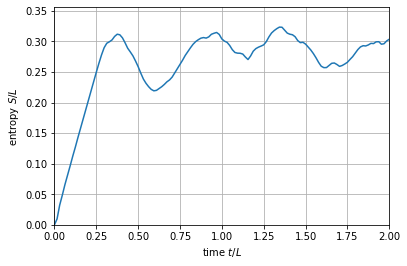

In [10]:
plt.xlabel(r"time $t/L$")
plt.ylabel(r"entropy $S/L$")
plt.xlim(np.min(data[:,0]/L),np.max(data[:,0]/L))
plt.ylim(np.min(data[:,1]/L),np.max(data[:,1]/L)*1.1)
plt.plot(data[:,0]/L,data[:,1]/L)
plt.grid()
plt.show()
plt.close()